In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wd-lstm-with-glove/word2vec.wordvectors
/kaggle/input/wd-lstm-with-glove/__results__.html
/kaggle/input/wd-lstm-with-glove/submission.csv
/kaggle/input/wd-lstm-with-glove/__notebook__.ipynb
/kaggle/input/wd-lstm-with-glove/__output__.json
/kaggle/input/wd-lstm-with-glove/custom.css
/kaggle/input/wd-lstm-with-glove/__results___files/__results___41_3.png
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install pytorch-nlp

     |████████████████████████████████| 90 kB 748 kB/s 


In [3]:
from collections import Counter
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler

import torchnlp
import torchnlp.nn as nlp_nn
import torchnlp.metrics as nlp_metrics
from torchnlp.samplers import BucketBatchSampler
from torchnlp.encoders.text import stack_and_pad_tensors
from torchnlp.encoders.text import SpacyEncoder


from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive

from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold



In [4]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Part 1: A bit of EDA

Let's look where the length of the text is small (< 5) but is still a real disaster

In [5]:
df_train.loc[df_train["text"].map(lambda t: len(t.split(' ')) < 5) & df_train["target"] == 1]

,id,keyword,location,text,target
73,105,accident,Australia,BigRigRadio Live Accident Awareness,1
94,136,accident,Alberta | Sask. | Montana,Suffield Alberta Accident https://t.co/bPTmlF4P10,1
247,352,annihilation,Wild Wild Web,annihilating quarterstaff of annihilation,1
300,442,apocalypse,NaN,Shadow boxing the apocalypse,1
321,467,armageddon,Here And There,Armageddon https://t.co/uCSUDk3q1d,1
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
991,1440,body%20bagging,302???? 815,@Yankees body bagging mfs,1
1315,1899,burning,NaN,My hand is burning,1
1853,2664,crush,NaN,Ina Buted Girl Crush??,1


Looks like the keyword really matter then. This is something to consider later.
Let's look where the keyword is Nan and try to see if it has 5 words or more


In [6]:
df_train.loc[df_train["keyword"].isna() & df_train["target"] == 1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


A part from the "Omg earthquake", everywhere the keyword is nan and a real disaster, the text is long enough

Ok. Let's process the text a bit

In [7]:
# Credit to https://www.kaggle.com/arijzou/text-preprocessing-disaster-tweets for these !
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "after midday",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


In [8]:
# Credit to https://www.kaggle.com/arijzou/text-preprocessing-disaster-tweets for this !
def fix_slangs(text):
  #first of all we need to change our text to lowercase to match the abbreviations, otherwise some words won't be changed
  #eg: NYC
    text = text.lower()
    sentence_list = text.split()
    new_sentence = []
    
    for word in sentence_list:
        for candidate_replacement in abbreviations:
            if (candidate_replacement == word):
                word = word.replace(candidate_replacement, abbreviations[candidate_replacement])
        new_sentence.append(word) 
  
    return (" ".join(new_sentence))

In [9]:
# Credit to https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
import re

http_pattern = re.compile('https?://[^\s]+')
#hashtag_pattern = re.compile('#[^\s]+')

def preprocess_text(df):
    #first lowercase it all
    df["text"] = df["text"].map(lambda s: s.lower())
    df["keyword"] = df["keyword"].map(lambda s: s.lower() if type(s) is str else s)
    #replace http(s)://[whatever] with just, well, 'http://whatever'
    df["text"] = df["text"].map(lambda s: s if re.search(http_pattern, s) is None else re.sub(http_pattern, 'http://whatever', s))
    #fix slangs
    df["text"] = df["text"].map(fix_slangs)
    #df['text'] = df['text'].map(lambda s: s if re.search(hashtag_pattern, s) is None else re.sub(hashtag_pattern, '', s))
    df["text"] = df["text"].map(remove_emoji)

    

preprocess_text(df_train)
preprocess_text(df_test)

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [12]:
df_test.loc[df_test["keyword"] == "typhoon"]

,id,keyword,location,text
3041,10062,typhoon,"Bengaluru, India",struggling to return to life: makurazaki typho...
3042,10063,typhoon,ID,obama declares disaster for typhoon-devastated...
3043,10065,typhoon,Breaking News,#map: typhoon soudelor's predicted path as it ...
3044,10068,typhoon,NaN,obama signs disaster declaration for northern ...
3045,10078,typhoon,NaN,typhoon soudelor heads for taiwan http://whate...
3046,10086,typhoon,"London, UK",uk weather alert: remnants of asian super typh...
3047,10094,typhoon,NaN,#trending #viral spectacular satellite view of...
3048,10095,typhoon,NaN,#worldnews #world saipan has no water electric...
3049,10096,typhoon,Edmonton,striking views of super typhoon soudelor as it...
3050,10097,typhoon,New York,saipan has no water electricity in aftermath o...


In [13]:
print(df_train["keyword"].iloc[7472])
print(df_train["keyword"].iloc[7582])

wreck
wrecked


Let's replace look alike keywords

In [14]:
keyword_replacement = {
    'annihilat':'',
    'arson':'',
    'attack':'',
    'bioterror':'',
    'blaz':'',
    'bleed':'blood',
    'blew':'blow',
    'blood':'',
    'blow':'',
    'body%20bag':'',
    'bomb':'',
    'bridge%20collapse':'collapse',
    'buildings%20on%20fire':'buildings%20burning',
    'burn':'',
    'catastroph':'',
    'collaps':'',
    'colli':'',
    'crash':'',
    'dea':'',
    'demolish':'',
    'derail':'',
    'destroy':'',
    'detonat':'',
    'devasta':'',
    'drown':'',
    'electrocute':'',
    'evacuat':'',
    'explo':'',
    'fatalit':'',
    'flood':'',
    'forest%20fire':'',
    'hazard':'',
    'hijack':'',
    'injur':'',
    'inudat':'',
    'mass%20murder':'',
    'natural%20disaster':'disaster',
    'nuclear%20disaster':'disaster',
    'obliter':'',
    'panic':'',
    'quarantin':'',
    'rescu':'',
    'scream':'',
    'suicide%20bomb':'',
    'terrori':'',
    'trauma':'',
    'weapon':'',
    'wild%20fires':'wildfire',
    'wound':'',
    'wreck':'',
}

In [15]:
def replace_keys(df):
    for key, rep in keyword_replacement.items():
        kr = re.compile('^'+key+'[a-zA-Z0-9%]+')
        for idx, k in df["keyword"].dropna().iteritems():
            if kr.search(k) is not None:
                df.at[idx, "keyword"] = key if rep == '' else rep
                
replace_keys(df_train)
replace_keys(df_test)

# Part 2: Training

In [16]:
hidden_size = 200
batch_size = 50

In [17]:
#First a naive bayes on keywords

#preprocess : change keyword as category, be careful about NaN
df_train["keywordstr"] = df_train["keyword"].fillna("NaN")
df_test["keywordstr"] = df_test["keyword"].fillna("NaN")

df_train["keywordstr"] = df_train["keywordstr"].astype('category')
df_test["keywordstr"] = df_test["keywordstr"].astype('category')

counter = Counter()
kstr = pd.concat([df_train["keywordstr"], df_test["keywordstr"]])
for string in kstr:
    counter.update([string])
    
keyword_vocab = Vocab(counter, specials=['<unk>'])

df_train["keyword_id"] = df_train["keywordstr"].map(lambda s: keyword_vocab.stoi[s])
df_test["keyword_id"] = df_test["keywordstr"].map(lambda s: keyword_vocab.stoi[s])

#Train only on non NaN
cnb_train = df_train[["keyword", "keyword_id", "target"]].dropna()

cnb = CategoricalNB()

X = np.array(cnb_train["keyword_id"]).reshape(-1, 1)
Y = np.array(cnb_train["target"])

cnb.fit(X, Y)
pred = cnb.predict(X)
print("Naive accuracy ", float((pred == Y).sum()) / Y.size)

pred_prob = cnb.predict_proba(X)
print(pred_prob[:,1])

#retain the cnb model for later

Naive accuracy  0.7217955508474576
[0.36557865 0.36557865 0.36557865 ... 0.42435885 0.42435885 0.42435885]


In [18]:
sorted(keyword_vocab.itos)

['<unk>',
 'NaN',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilat',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'attack',
 'avalanche',
 'battle',
 'bioterror',
 'blaz',
 'blight',
 'blizzard',
 'blood',
 'blow',
 'body%20bag',
 'bomb',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burn',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastroph',
 'chemical%20emergency',
 'cliff%20fall',
 'collaps',
 'colli',
 'crash',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dea',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolition',
 'derail',
 'desolate',
 'desolation',
 'destroy',
 'destruction',
 'detonat',
 'devasta',
 'disaster',
 'displaced',
 'drought',
 'drown',
 'dust%20storm',
 'earthquake',
 'electrocute',
 'emergency',
 'emergency%20plan',
 'emergency%20services',
 'engulfed',
 'epicentre',
 'evacuat',
 'explo',
 'eyewitness',
 'famine',
 'fatal',
 'fatalit',
 'fear',
 'fire',
 

In [19]:
#Now NLP stuff

#get "vocab" (word to int, int to word object)
whole_text = pd.concat([df_train["text"], df_test["text"]])

en_tokenizer = get_tokenizer('spacy', language='en')

counter = Counter()
for string in whole_text:
    counter.update(en_tokenizer(string))
    
whole_vocab = Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

print("dict word to int")
for (token, num) in whole_vocab.stoi.items():
    print((token, num))
    if num > 8: break;
print("list int to word")
whole_vocab.itos[0:10]

dict word to int
('<unk>', 0)
('<pad>', 1)
('<bos>', 2)
('<eos>', 3)
('http://whatever', 4)
('#', 5)
('the', 6)
('?', 7)
('.', 8)
('a', 9)
list int to word


['<unk>',
 '<pad>',
 '<bos>',
 '<eos>',
 'http://whatever',
 '#',
 'the',
 '?',
 '.',
 'a']

In [20]:
#numericalizer
def encode_str(example):
    return torch.flip(torch.tensor([whole_vocab[token] for token in en_tokenizer(example)], dtype=torch.long), [0])

#tokenizer
def tokenize_str(example):
    l = [token for token in en_tokenizer(example)]
    l.reverse()
    return l

df_train["tokenized"] = [tokenize_str(example) for example in df_train["text"]]
df_test["tokenized"] = [tokenize_str(example) for example in df_test["text"]]

df_train["encoded"] = [encode_str(example) for example in df_train["text"]]
df_test["encoded"] = [encode_str(example) for example in df_test["text"]]

In [21]:
df_train["tokenized"].head()

0    [all, us, forgive, allah, may, earthquake, #, ...
1     [canada, ., sask, ronge, la, near, fire, forest]
2    [expected, are, orders, place, in, shelter, or...
3    [california, in, orders, evacuation, wildfires...
4    [school, a, into, pours, wildfires, #, from, s...
Name: tokenized, dtype: object

In [22]:
df_train["encoded"].head()

0    [tensor(58), tensor(110), tensor(4045), tensor...
1    [tensor(1324), tensor(8), tensor(20035), tenso...
2    [tensor(1271), tensor(34), tensor(1767), tenso...
3    [tensor(123), tensor(11), tensor(1767), tensor...
4    [tensor(233), tensor(9), tensor(88), tensor(19...
Name: encoded, dtype: object

In [23]:
import torchtext as text
import os
import shutil

# Input dir as cache: click on "+ Add data" on the left then "Notebook output", "Your work". This allows to import previous output
if os.path.exists('/kaggle/input/awd-lstm'):
    if not os.path.exists('./awd-lstm'):
        shutil.copytree('/kaggle/input/awd-lstm', './awd-lstm')
else:
    try:
        os.makedirs('./awd-lstm')
    except FileExistsError as e:
        print('./awd-lstm already exists')

vec = text.vocab.GloVe(name='twitter.27B', dim=hidden_size, cache='./awd-lstm')

embedding = vec.get_vecs_by_tokens(whole_vocab.itos, lower_case_backup=True)
print(embedding.shape)

./awd-lstm/glove.twitter.27B.zip: 1.52GB [04:49, 5.25MB/s]                            
100%|█████████▉| 1193513/1193514 [01:48<00:00, 11032.01it/s]


torch.Size([22627, 200])


In [24]:
# train word2vec model to get specially trained embedding
# see https://wiki.pathmind.com/word2vec
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors

# whole_tokenized = pd.concat([df_train["tokenized"], df_test["tokenized"]])

#if not os.path.exists("./word2vec.wordvectors"):
#    model_w2v = Word2Vec(whole_tokenized, size=hidden_size, window=3, min_count=2, sg=1)
#    model_w2v.train(whole_tokenized, total_examples=len(whole_tokenized) , epochs=100)
#    model_w2v.save("./word2vec.wordvectors")

#wv = KeyedVectors.load("./word2vec.wordvectors", mmap='r')

In [25]:
#embedding = [wv[word] if word in wv else np.random.rand(hidden_size) for word in whole_vocab.itos]
#embedding = torch.tensor(embedding).float()
#print(embedding.shape)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
embedding = embedding.to(device)

In [28]:
dict_train = df_train.to_dict('records', into=OrderedDict)
dict_train[0]

OrderedDict([('id', 1),
             ('keyword', nan),
             ('location', nan),
             ('text',
              'our deeds are the reason of this #earthquake may allah forgive us all'),
             ('target', 1),
             ('keywordstr', 'NaN'),
             ('keyword_id', 42),
             ('tokenized',
              ['all',
               'us',
               'forgive',
               'allah',
               'may',
               'earthquake',
               '#',
               'this',
               'of',
               'reason',
               'the',
               'are',
               'deeds',
               'our']),
             ('encoded',
              tensor([  58,  110, 4045, 1816,  172,  274,    5,   31,   13,  877,    6,   34,
                      6557,  133]))])

In [29]:
# Function for folds and data loader

def collate_fn(batch):
    #print("{}".format(encode_str(batch[0]['text'])))
    #stack_and_pad_format along dim=0, so seq_len is the first dimension
    padded, _ = stack_and_pad_tensors([row['encoded'] for row in batch]) #encoded
    target, _ = stack_and_pad_tensors([torch.tensor([row['target']]) for row in batch]) #target
    indexes = torch.tensor([row['id'] for row in batch])
    
    #Transpose because LSTM has seq_size has first dim by default
    return (padded.t_(), target.float(), indexes)

def to_dataloader(data):
    data_sampler = SequentialSampler(data)

    data_batch_sampler = BucketBatchSampler(
        data_sampler, batch_size, True)

    data_iterator = DataLoader(
        data,
        batch_sampler=data_batch_sampler,
        collate_fn=collate_fn,
        pin_memory=True)
    
    return data_iterator



In [30]:
def get_precision(out, target):
    true_positives = (out * target).sum()
    out_positives = out.sum()
    return true_positives.float() / (out_positives.float() + 1e-10)

def get_recall(out, target):
    true_positives = (out * target).sum()
    target_positives = target.sum()
    return true_positives.float() / (target_positives.float() + 1e-10)

def get_f1(out, target):
    prec = get_precision(out, target)
    rec = get_recall(out, target)
    return 2 * prec * rec / (prec + rec + 1e-10)

The actual model:

In [31]:
def get_h_c(batch_size, hidden_size, num_dir=1):
    return [torch.rand(num_dir, batch_size, hidden_size).to(device) for _ in range(2)]
    

class WdLstm(nn.Module):
    def __init__(self, vocab_size=0, hidden_size=0, wd=0, d=0, bidir=False, attention=False, emb_weights = None):
        super(WdLstm, self).__init__()
        
        self.bidir = bidir
        self.attention = attention
        
        if emb_weights is None:
            self.emb = nn.Embedding(vocab_size, hidden_size)
        else:
            self.emb = nn.Embedding.from_pretrained(emb_weights)
        self.drop = nn.Dropout(d)
        
        self.lin_attn = nn.Linear(2 * hidden_size, hidden_size)
        
        self.rnn_e = nlp_nn.WeightDropLSTM(hidden_size, hidden_size, 1, weight_dropout=wd, bidirectional=bidir, batch_first=False)
        self.rnn_d = nlp_nn.WeightDropLSTM(hidden_size, hidden_size, 1, weight_dropout=wd, bidirectional=bidir, batch_first=False)

        self.lin_out = nn.Linear(hidden_size, 1)
                
    def forward(self, x, h_c):
        #From https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # The first output is of shape (seq_len, batch, num_directions * hidden_size): 
        # tensor containing the output features (h_t) from the last layer of the LSTM, for each t
        # or (batch, seq_len, num_dir * hidden_size) if batch_first=True
        # In short, it is a concatenation of all h_t
        # Whereas the second output (h_n) is the last h_t, of size (num_layers * num_directions, batch, hidden_size)
        # (c_n is the cell state ofc)
        
        embedded = self.drop(self.emb(x))
        
        out,(h_n,c_n) = self.rnn_e(embedded, h_c)

        if self.attention:
            seq_len = out.shape[0]
            num_dir = 2 if self.bidir else 1
            batch_size = embedded.shape[1]
            hidden_size = embedded.shape[2]
            
            h_ns = torch.cat([h_n] * seq_len, dim=0).view(-1, batch_size, hidden_size) # (seq_len * num_layers(=1) * num_dir, batch, hidden_size)
            out = out.view(seq_len, batch_size, num_dir, hidden_size).permute(0, 2, 1, 3).reshape(-1, batch_size, hidden_size) # (seq_len * num_dir, batch, hidden_size)
            h_o = torch.cat([h_ns, out], dim=2) #(seq_len * num_dir, batch, 2 * hidden_size)
            
            w_attn = nn.Parameter(F.softmax(torch.tanh(self.lin_attn(h_o)), dim=-1)) #(seq_len * num_dir, batch, hidden_size)
        
            # yeah yeah some part of w_attn is dropped...
            # offset = 2 if self.bidir else 1
            
            # w_attn = w_attn.split([embedded.shape[0], offset])[0] # (seq, batch, 1)
            # w_attn = w_attn.permute(1, 2, 0) # (batch, 1, seq)

            # (seq, 1, batch, hidden_size) * (seq, num_dir, batch, hidden_size)
            applied_attn = embedded.unsqueeze(1) * w_attn.view(seq_len, num_dir, batch_size, hidden_size) # (seq_len, num_dir, batch, hidden_size)
            embedded = torch.cat([embedded, applied_attn.view(seq_len * num_dir, batch_size, hidden_size)], dim=0) #(seq_len + seq_len * num_dir, batch, hidden_size)
        
            out,(h_n,c_n) = self.rnn_d(embedded, (h_n,c_n))
        
        return self.lin_out(h_n[-1]),(h_n.detach(), c_n.detach())
            
    def learn_embed(self, yes):
        #For freezing the embedding
        if yes != self.emb.weight.requires_grad:
            self.emb.weight.requires_grad_(requires_grad=yes)
        

In [32]:
# FIXES : cannot assign 'torch.cuda.FloatTensor' as parameter 'weight_hh_l0' (torch.nn.Parameter or None expected)
from torch.nn import Parameter

def _weight_drop(module, weights, dropout):
    """
    Helper for `WeightDrop`.
    """

    for name_w in weights:
        w = getattr(module, name_w)
        del module._parameters[name_w]
        module.register_parameter(name_w + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_w in weights:
            raw_w = getattr(module, name_w + '_raw')
            w = Parameter(torch.nn.functional.dropout(raw_w, p=dropout, training=module.training))
            setattr(module, name_w, w)

        return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)
    
torchnlp.nn.weight_drop._weight_drop = _weight_drop

In [33]:
def init_model(lr, wd, d, bidir=False, attention=False):
    model = WdLstm(hidden_size=hidden_size,
                wd=wd,
                d=d,
                bidir=bidir,
                attention=attention,
                emb_weights = embedding)
    
    model.learn_embed(False)
    opt = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    
    model = model.to(device)
    
    return model,opt,criterion

In [34]:
torch.manual_seed(42)
np.random.seed(42)

def train(lr, d, bidir, attention, num_epochs=30, monitor_period=100):
    print("training with lr {}, d {}, bidir {}, attention {}, num_epochs {}".format(lr,d,bidir,attention, num_epochs))
    
    # Perf monitoring
    train_loss = np.array([])
    train_acc = np.array([])
    train_f1 = np.array([])
        
    h_c = get_h_c(batch_size, hidden_size, num_dir=2 if bidir else 1)
    model, opt, criterion = init_model(lr, d, d, bidir=bidir, attention=attention)
        
    for epoch in range(0, num_epochs):
        train_iterator = to_dataloader(dict_train)
        for idx, (batch_in, batch_target, indexes) in enumerate(train_iterator):
            batch_in = batch_in.detach().clone().to(device)
            batch_target = batch_target.detach().clone().to(device)         

            opt.zero_grad()

            #reset hidden_state
            for h in h_c: h.zero_()

            out,h_c = model(batch_in, h_c)
            loss = criterion(out, batch_target)

            #gradient clipping
            _ = torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            loss.backward()
            opt.step()

            if (epoch * idx) % monitor_period == monitor_period - 1 :
                pred = (out > 0.0).float()
                
                l = loss.item()
                acc,_,_ = nlp_metrics.get_accuracy(batch_target, pred)
                f1 = get_f1(pred, batch_target).cpu()
                
                train_loss = np.append(train_loss, l)
                train_acc = np.append(train_acc, acc)
                train_f1 = np.append(train_f1, f1)
                
                print("epoch : {}, loss {:.2f}, train_acc {:.2f}, train_f1 {:.2f}, seq_size {}".format(epoch, l, acc, f1, batch_in.shape[0]))

    return (train_f1, train_acc, train_loss, model)

training with lr 0.3, d 0.45, bidir True, attention True, num_epochs 60


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


epoch : 1, loss 0.57, train_acc 0.78, train_f1 0.15, seq_size 60
epoch : 3, loss 0.44, train_acc 0.80, train_f1 0.77, seq_size 31
epoch : 3, loss 0.32, train_acc 0.90, train_f1 0.83, seq_size 30
epoch : 7, loss 0.43, train_acc 0.88, train_f1 0.77, seq_size 37
epoch : 9, loss 0.58, train_acc 0.72, train_f1 0.36, seq_size 32
epoch : 9, loss 0.44, train_acc 0.78, train_f1 0.27, seq_size 33
epoch : 11, loss 0.57, train_acc 0.68, train_f1 0.43, seq_size 37
epoch : 11, loss 0.33, train_acc 0.86, train_f1 0.89, seq_size 36
epoch : 13, loss 0.45, train_acc 0.80, train_f1 0.55, seq_size 29
epoch : 13, loss 0.21, train_acc 0.96, train_f1 0.97, seq_size 30
epoch : 17, loss 0.44, train_acc 0.78, train_f1 0.83, seq_size 33
epoch : 17, loss 0.38, train_acc 0.84, train_f1 0.64, seq_size 32
epoch : 19, loss 0.56, train_acc 0.70, train_f1 0.69, seq_size 32
epoch : 19, loss 0.30, train_acc 0.86, train_f1 0.87, seq_size 32
epoch : 21, loss 0.63, train_acc 0.72, train_f1 0.56, seq_size 33
epoch : 21, loss

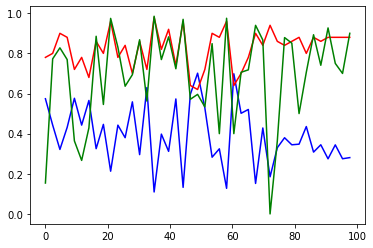

acc 0.7846161365509033, f1 0.8640000000000001


In [35]:
from matplotlib import pyplot as plt

config_wd_lstm_simple = {'lr':0.3, 'd':0.25, 'bidir':False, 'attention':False, 'num_epochs':150 }
config_wd_lstm_bidir = {'lr':0.3, 'd':0.45, 'bidir':True, 'attention':False, 'num_epochs':60 }
config_wd_lstm_bidir_attention = {'lr':0.3, 'd':0.45, 'bidir':True, 'attention':True, 'num_epochs':60 }

#f1_arr, acc_arr, loss_arr, model  = train(**config_wd_lstm_simple)
#f1_arr, acc_arr, loss_arr, model = train(**config_wd_lstm_bidir)
f1_arr, acc_arr, loss_arr, model = train(**config_wd_lstm_bidir_attention)

fig, ax = plt.subplots()

t = np.arange(0.0, 100.0, 100.0 / len(f1_arr))

ax.plot(t, loss_arr, color="Blue")
ax.plot(t, acc_arr, color="Red")
ax.plot(t, f1_arr, color="Green")

plt.show()

print("acc {}, f1 {}".format(f1_arr[-10:].mean(), acc_arr[-10:].mean()))

param = config_wd_lstm_bidir

# Part 3: Test

In [36]:
dict_test = df_test.to_dict('records', into=OrderedDict)

In [37]:
def collate_fn_test(batch):
    padded, _ = stack_and_pad_tensors([row['encoded'] for row in batch])
    keywords_ids = np.array([row['keyword_id'] for row in batch]).reshape(-1, 1)
    
    #Transpose because LSTM has seq_size has first dim by default
    return padded.t_(),keywords_ids

In [38]:
test_iterator = DataLoader(
    dict_test,
    batch_size=1,
    shuffle=None,
    drop_last=False,
    collate_fn=collate_fn_test,
    pin_memory=True)

In [39]:
torch.tensor([[0]]).shape

torch.Size([1, 1])

In [40]:
#remind the gnb model
def ensemble_predict(h_c, batch, input_cnb):
    out_lstm,h_c = model(batch, h_c)
    
    out_lstm = out_lstm.sigmoid().cpu()
    
    out_cnb = cnb.predict_proba(input_cnb) if input_cnb != keyword_vocab.stoi["NaN"] else np.array([[0.5, 0.5]])
    out_cnb = out_cnb[:, 1] #classes are 0 or 1, so the second column is the proba of 1
        
    pred = (((out_lstm + out_cnb) / 2.) > 0.5).int()
    
    return pred

In [41]:
%%capture
num_dir = 2 if param['bidir'] else 1
h_c = get_h_c(1, hidden_size, num_dir)


test_out = torch.tensor([])
model.eval()
with torch.no_grad():
    for idx, (test_batch, keys_ids) in enumerate(test_iterator):
        test_batch = test_batch.detach().clone().to(device)
        
        #reset hidden_state
        for h in h_c: h.zero_()
        
        pred = ensemble_predict(h_c, test_batch, keys_ids)
        
        test_out = torch.cat((test_out, pred), 0)
        
test_out = test_out.int().squeeze()
test_out.shape

In [42]:
submission = pd.DataFrame({'id':df_test['id'], 'target':test_out.cpu()})
submission.to_csv('./submission.csv', index=False)
print("Success")

Success
